<a href="https://colab.research.google.com/github/aamirattara/Quantitative-Finance/blob/main/Modern_Portfolio_Theory_using_Sharpe_Ratio_Machine_Learning_and_backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  51 of 51 completed


[*********************100%***********************]  1 of 1 completed



=== Rolling Backtest Results (2020–2025) ===
Portfolio Cumulative Return: 1558.43%
Benchmark Cumulative Return: 90.33%
Portfolio Sharpe Ratio: 2.93
Benchmark Sharpe Ratio: 0.89


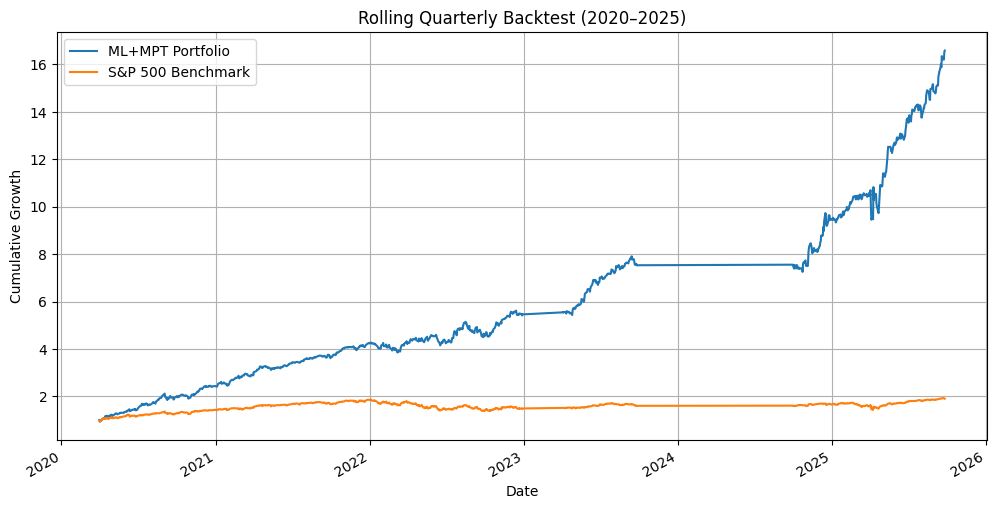

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

# ---------------- PARAMETERS ----------------
tickers = [
    "AAPL","MSFT","GOOGL","AMZN","NVDA","META","TSLA","BRK-B","JNJ","JPM",
    "V","UNH","PG","XOM","MA","HD","LLY","PEP","KO","AVGO","BAC","ABBV","MRK",
    "CVX","COST","WMT","ADBE","PFE","DIS","CSCO","MCD","NFLX","ACN","TMO","ABT",
    "CRM","WFC","LIN","TXN","DHR","NKE","NEE","INTC","AMD","PM","HON","AMGN","UNP","ORCL","IBM","CAT"
]  # user can extend this list
top_n = 10   # number of stocks to pick
benchmark = "^GSPC"
start, end = "2018-01-01", "2025-09-26"
risk_free_rate = 0.03

# ---------------- DOWNLOAD DATA ----------------
print("Downloading stock data...")
stock_data = yf.download(tickers, start=start, end=end, auto_adjust=True)
print("Downloading benchmark data...")
bench_data = yf.download(benchmark, start=start, end=end, auto_adjust=True)

#Ensure Consistency in Column Naming - Sometimes auto_adjust=True still puts data under 'Close' column. This ensures we uniformly refer to it as 'Adj Close'.
if 'Close' in stock_data.columns:
    stock_data = stock_data.rename(columns={'Close': 'Adj Close'})
if 'Close' in bench_data.columns:
    bench_data = bench_data.rename(columns={'Close': 'Adj Close'})

#Select Just the Prices You Need
stock_data = stock_data['Adj Close']
bench_data = bench_data['Adj Close']

# Compute returns
returns = stock_data.pct_change().dropna()
bench_returns = bench_data.pct_change().dropna()
returns[benchmark] = bench_returns

# ---------------- FEATURE ENGINEERING ----------------
def build_features(returns, tickers, benchmark):
    features, labels = {}, {}
    for t in tickers:
        df = pd.DataFrame(index=returns.index)
        df["1M_ret"] = returns[t].rolling(21).mean()
        df["3M_ret"] = returns[t].rolling(63).mean()
        df["6M_ret"] = returns[t].rolling(126).mean()
        df["Vol"]    = returns[t].rolling(63).std() * np.sqrt(252)
        df["Sharpe"] = df["3M_ret"] / df["Vol"]
        df["Drawdown"] = (returns[t].cumsum() - returns[t].cumsum().cummax())
        df["Beta"] = returns[t].rolling(63).cov(returns[benchmark]) / returns[benchmark].rolling(63).var()

        # Target: outperform benchmark next 3 months
        future_ret = returns[t].rolling(63).mean().shift(-63)
        bench_ret  = returns[benchmark].rolling(63).mean().shift(-63)
        df["Target"] = (future_ret > bench_ret).astype(int)

        df = df.dropna()
        if df.empty:
            continue
        features[t] = df.drop("Target", axis=1)
        labels[t] = df["Target"]
    return features, labels

features, labels = build_features(returns, tickers, benchmark)

# ---------------- PORTFOLIO OPTIMIZATION ----------------
def neg_sharpe(weights, mean_returns, cov_matrix, risk_free=risk_free_rate):
    port_ret = np.dot(weights, mean_returns) * 252
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return -(port_ret - risk_free) / port_vol

def optimize_portfolio(sel_returns, min_w=0.05, max_w=0.2):
    mean_returns = sel_returns.mean()
    cov_matrix   = sel_returns.cov()
    num_assets   = len(mean_returns)
    constraints = ({'type':'eq','fun': lambda x: np.sum(x) - 1})
    bounds = tuple((min_w, max_w) for _ in range(num_assets))
    init_guess = num_assets * [1./num_assets]
    result = minimize(neg_sharpe, init_guess,
                      args=(mean_returns, cov_matrix),
                      method="SLSQP", bounds=bounds, constraints=constraints)
    return result.x

# ---------------- ROLLING QUARTERLY BACKTEST ----------------
portfolio_returns = []
benchmark_returns = []

train_start = "2018-01-01"
first_test = "2020-01-01"  # start backtest after 2 years of training

for rebalance_date in pd.date_range(first_test, end, freq="Q"):
    # Training window: all data up to rebalance_date
    train_feats, train_labels = [], []
    for t in features:
        df = pd.concat([features[t].loc[:rebalance_date], labels[t].loc[:rebalance_date]], axis=1).dropna()
        if df.empty:
            continue
        X_t = df.drop("Target", axis=1).to_numpy()
        y_t = df["Target"].to_numpy()
        train_feats.append(X_t)
        train_labels.append(y_t)
    if not train_feats:
        continue
    X_train = np.vstack(train_feats)
    y_train = np.hstack(train_labels)

    # Train model
    model = RandomForestClassifier(n_estimators=300, max_depth=6, random_state=42)
    model.fit(X_train, y_train)

    # Predict for each stock using latest data
    latest_probs = {}
    for t in tickers:
        try:
            row = features[t].loc[rebalance_date].values.reshape(1, -1)
            prob = model.predict_proba(row)[0,1]
            latest_probs[t] = prob
        except:
            continue

    # Select top N stocks
    top_stocks = sorted(latest_probs, key=latest_probs.get, reverse=True)[:top_n]
    sel_returns = returns[top_stocks].loc[rebalance_date:].iloc[:63]  # hold for 3 months (~63 days)
    if sel_returns.empty:
        continue

    # Optimize portfolio
    weights = optimize_portfolio(sel_returns)
    port_ret = (sel_returns * weights).sum(axis=1)
    portfolio_returns.append(port_ret)

    # Benchmark for same period
    bench_ret = returns[benchmark].loc[rebalance_date:].iloc[:63]
    benchmark_returns.append(bench_ret)

# ---------------- RESULTS ----------------
portfolio_returns = pd.concat(portfolio_returns)
benchmark_returns = pd.concat(benchmark_returns)

cumulative_portfolio = (1 + portfolio_returns).cumprod()
cumulative_benchmark = (1 + benchmark_returns).cumprod()

print("\n=== Rolling Backtest Results (2020–2025) ===")
print(f"Portfolio Cumulative Return: {cumulative_portfolio.iloc[-1]-1:.2%}")
print(f"Benchmark Cumulative Return: {cumulative_benchmark.iloc[-1]-1:.2%}")

sharpe_portfolio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)
sharpe_benchmark = benchmark_returns.mean() / benchmark_returns.std() * np.sqrt(252)
print(f"Portfolio Sharpe Ratio: {sharpe_portfolio:.2f}")
print(f"Benchmark Sharpe Ratio: {sharpe_benchmark:.2f}")

# ---------------- PLOTS ----------------
plt.figure(figsize=(12,6))
cumulative_portfolio.plot(label="ML+MPT Portfolio")
cumulative_benchmark.plot(label="S&P 500 Benchmark")
plt.title("Rolling Quarterly Backtest (2020–2025)")
plt.ylabel("Cumulative Growth")
plt.legend()
plt.grid(True)
plt.show()
